In [1]:
from utils import compute_f1, load_data
from text_train.imports import *
from text_train.data import TextDS, text_to_device
from arcface import ArcMarginProduct
from text_train.model import EMBBert
from text_train.train import *
np.random.seed(1337)
device = torch.device('cuda')

In [2]:
from imports import *

## BERT multilingual

### Split

In [3]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [4]:
bs = 32
bs_val = 128
max_length=200
agg = 'mean'
language_model = 'bert-base-multilingual-uncased'
tokenizer = BertTokenizer.from_pretrained(language_model)

tr_ds = TextDS(train_df, tokenizer, max_length=max_length)
val_ds = TextDS(val_df, tokenizer, max_length=max_length)
full_ds = TextDS(df, tokenizer, max_length=max_length)

torch.save(tr_ds, 'data/text_models/datasets/tr_ds_0.3_{}.pth'.format(max_length))
torch.save(val_ds, 'data/text_models/datasets/val_ds_0.3_{}.pth'.format(max_length))
torch.save(full_ds, 'data/text_models/datasets/full_ds_0.3_{}.pth'.format(max_length))

In [5]:
tr_ds = torch.load('data/text_models/datasets/tr_ds_0.3_{}.pth'.format(max_length))
val_ds = torch.load('data/text_models/datasets/val_ds_0.3_{}.pth'.format(max_length))
full_ds = torch.load('data/text_models/datasets/full_ds_0.3_{}.pth'.format(max_length))

In [6]:
tr_test_dl = DataLoader(tr_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
#full_dl = DataLoader(full_ds, batch_size = bs_val, shuffle = False, pin_memory = True)

In [7]:
# model
model = EMBBert(language_model, agg=agg).to(device)

In [8]:
centers = compute_centers(tr_test_dl, model, train_df)
torch.save(centers, 'data/text_models/centers_0.3_{}_{}_{}.pth'.format(agg, max_length, language_model))

IndexError: index 10375 is out of bounds for dimension 0 with size 10322

In [ ]:
%debug

> c:\users\admin\documents\shopee\text_train\train.py(226)compute_centers()
    224     centers = torch.zeros(len(label_indexes), embs.shape[1]).to('cuda')
    225     for i in range(len(label_indexes)) :
--> 226         centers[i] = embs[label_indexes.iloc[i].values[0]].mean(dim=0)
    227     return centers
    228 

ipdb> label_indexes
                                                          indx
label_group                                                   
0                                                 [2353, 3767]
1            [3567, 4569, 4625, 4758, 5344, 5655, 6162, 668...
2                                                 [1494, 6620]
3                                                 [7722, 9474]
4                                                  [692, 2534]
...                                                        ...
3299                                        [1545, 5554, 9912]
3300                                        [1670, 1684, 8899]
3301                         

In [8]:
centers = torch.load('data/text_models/centers_0.3_{}_{}_{}.pth'.format(agg, max_length, language_model))

In [9]:
metric_fc = ArcMarginProduct(512, train_df['label_group'].nunique(), s=30, m=0.5,
                             easy_margin=False, centers=centers, device=device).to(device)

Using center as wieghts


In [10]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=5e-4, n_epochs=5)
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [11]:
unfreeze_bert_to(model, 10)

Unfroze 32 parameters


In [12]:
loss_hist = []
best_thr_score={'val': {'thr': None, 'f1': None}, 'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/text_models/test_12ap_epochs'

In [13]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start, device=device)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/text_models/test_12ap_epochs_ep_0.pth


Saved best model ep 0 with f score : 0.6134224358446186
Ep 0: Train loss 9.9623 | Val f score 0.6134 with thresh 0.73, train f score 0.5879 with thresh 0.73


Saved best model ep 1 with f score : 0.6403566809792569
Ep 1: Train loss 8.4241 | Val f score 0.6404 with thresh 0.73, train f score 0.6738 with thresh 0.83


Checkpoint : saved model to data/text_models/test_12ap_epochs_ep_2.pth


Saved best model ep 2 with f score : 0.655571273586006
Ep 2: Train loss 5.8388 | Val f score 0.6556 with thresh 0.78, train f score 0.7725 with thresh 0.93


Saved best model ep 3 with f score : 0.6628752112823555
Ep 3: Train loss 3.6691 | Val f score 0.6629 with thresh 0.83, train f score 0.8363 with thresh 0.93


Checkpoint : saved model to data/text_models/test_12ap_epochs_ep_4.pth


Saved best model ep 4 with f score : 0.66618577123748
Ep 4: Train loss 2.5325 | Val f score 0.6662 with thresh 0.83, train f score 0.8756 with thresh 0.93


In [14]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=1e-4, n_epochs=2)
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [15]:
unfreeze_bert_to(model, 6)

Unfroze 96 parameters


In [16]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start, device=device)
loss_hist.append(losses)
ep_start += n_epochs

Saved best model ep 5 with f score : 0.6691313062397024
Ep 5: Train loss 2.6464 | Val f score 0.6691 with thresh 0.83, train f score 0.8754 with thresh 0.93


Checkpoint : saved model to data/text_models/test_12ap_epochs_ep_6.pth


Saved best model ep 6 with f score : 0.672848153774134
Ep 6: Train loss 1.9609 | Val f score 0.6728 with thresh 0.83, train f score 0.9053 with thresh 0.93


In [17]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=1e-5, n_epochs=2)
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [18]:
unfreeze(model)

In [19]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start, device=device)
loss_hist.append(losses)
ep_start += n_epochs

Saved best model ep 7 with f score : 0.6760731523704145
Ep 7: Train loss 1.5734 | Val f score 0.6761 with thresh 0.83, train f score 0.9226 with thresh 0.93


Checkpoint : saved model to data/text_models/test_12ap_epochs_ep_8.pth


Ep 8: Train loss 1.3791 | Val f score 0.6760 with thresh 0.83, train f score 0.9332 with thresh 0.93


In [21]:
def plot_hist(history) : 
    train_scores = [info['train']['f1'] for info in history]
    train_thr = [info['train']['thr'] for info in history]
    val_scores = [info['val']['f1'] for info in history]
    val_thr = [info['val']['thr'] for info in history]
    x = range(len(train_scores))
    plt.plot(x, val_scores, label='val_score')
    plt.plot(x, train_scores, label='train_score')
    plt.legend()
    plt.show()
    plt.plot(x, val_thr, label='val_thr')
    plt.plot(x, train_thr, label='train_thr')
    plt.legend()
    plt.show()

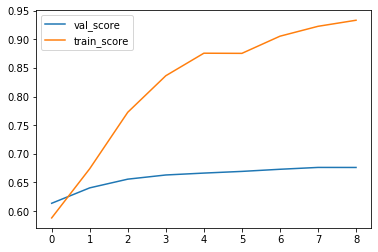

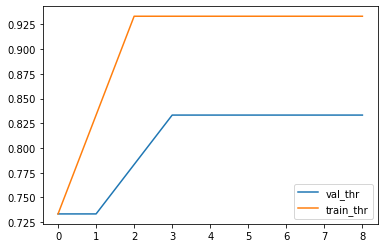

In [22]:
plot_hist(thr_score_hist)

### full train

In [1]:
from utils import compute_f1, load_data
from text_train.imports import *
from text_train.data import TextDS, text_to_device
from arcface import ArcMarginProduct
from text_train.model import EMBBert
from text_train.train import *
np.random.seed(1337)
device = torch.device('cuda')

In [2]:
from imports import *

In [3]:
def plot_hist(history) : 
    train_scores = [info['train']['f1'] for info in history]
    train_thr = [info['train']['thr'] for info in history]
    val_scores = [info['val']['f1'] for info in history]
    val_thr = [info['val']['thr'] for info in history]
    x = range(len(train_scores))
    plt.plot(x, val_scores, label='val_score')
    plt.plot(x, train_scores, label='train_score')
    plt.legend()
    plt.show()
    plt.plot(x, val_thr, label='val_thr')
    plt.plot(x, train_thr, label='train_thr')
    plt.legend()
    plt.show()

#### Prep data and model

In [4]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=1)

In [5]:
bs = 64
bs_val = 128
max_length=200
agg = 'mean'
language_model = 'bert-base-multilingual-uncased'
tokenizer = BertTokenizer.from_pretrained(language_model)

tr_ds = TextDS(train_df, tokenizer, max_length=max_length)
full_ds = TextDS(df, tokenizer, max_length=max_length)

torch.save(tr_ds, 'data/text_models/datasets/tr_ds_full_{}.pth'.format(max_length))
torch.save(full_ds, 'data/text_models/datasets/full_ds_full_{}.pth'.format(max_length))

In [6]:
tr_ds = torch.load('data/text_models/datasets/tr_ds_full_{}.pth'.format(max_length))
full_ds = torch.load('data/text_models/datasets/full_ds_full_{}.pth'.format(max_length))

In [7]:
tr_test_dl = DataLoader(tr_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)
#full_dl = DataLoader(full_ds, batch_size = bs_val, shuffle = False, pin_memory = True)

In [8]:
model = EMBBert(language_model, agg=agg).to(device)

centers = compute_centers(tr_test_dl, model, train_df)
torch.save(centers, 'data/text_models/centers_0.3_{}_{}_{}.pth'.format(agg, max_length, language_model))

In [9]:
centers = torch.load('data/text_models/centers_0.3_{}_{}_{}.pth'.format(agg, max_length, language_model))

In [10]:
metric_fc = ArcMarginProduct(512, train_df['label_group'].nunique(), s=30, m=0.5,
                             easy_margin=False, centers=centers, device=device).to(device)

Using center as wieghts


In [11]:
loss_hist = []
best_thr_score={'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/text_models/2april'

#### First train

In [11]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=5e-4, n_epochs=5)
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [12]:
unfreeze_bert_to(model, 10)

Unfroze 32 parameters


In [14]:
best_thr_score, thr_score_hist, losses = train_full_data(model, optimizer, lf, sched, metric_fc, tr_dl,
                                               n_epochs, train_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/text_models/2april_ep_0.pth
Ep 0: Loss 10.9213 | F score 0.5386 with thresh 0.73


Ep 1: Loss 9.6618 | F score 0.6101 with thresh 0.83


Checkpoint : saved model to data/text_models/2april_ep_2.pth
Ep 2: Loss 7.4889 | F score 0.6702 with thresh 0.88


Ep 3: Loss 5.5096 | F score 0.7203 with thresh 0.93


Checkpoint : saved model to data/text_models/2april_ep_4.pth
Ep 4: Loss 4.3183 | F score 0.7519 with thresh 0.93


In [15]:
torch.save(metric_fc.state_dict(), save_path+'_met_1fr.pth')

#### Second train

In [14]:
metric_fc.load_state_dict(torch.load(save_path+'_met_1fr.pth'))

<All keys matched successfully>

In [15]:
model.load_state_dict(torch.load('data/text_models/2april_ep_4.pth'))

<All keys matched successfully>

In [16]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=1e-4, n_epochs=5)
ep_start = 5
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [17]:
freeze(model)
unfreeze_bert_to(model, 6)

Unfroze 96 parameters


In [18]:
bs = 64
tr_test_dl = DataLoader(tr_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)

In [19]:
best_thr_score, thr_score_hist, losses = train_full_data(model, optimizer, lf, sched, metric_fc, tr_dl,
                                               n_epochs, train_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Ep 5: Loss 4.1489 | F score 0.7635 with thresh 0.91


Checkpoint : saved model to data/text_models/2april_ep_6.pth
Ep 6: Loss 4.2318 | F score 0.7689 with thresh 0.91


Ep 7: Loss 3.5823 | F score 0.7966 with thresh 0.91


Checkpoint : saved model to data/text_models/2april_ep_8.pth
Ep 8: Loss 2.9327 | F score 0.8247 with thresh 0.91


Ep 9: Loss 2.5338 | F score 0.8433 with thresh 0.91


In [17]:
torch.save(metric_fc.state_dict(), save_path+'_met_3fr.pth')
torch.save(model.state_dict(), save_path+'_mod_3fr.pth')

#### Third train

In [12]:
model.load_state_dict(torch.load(save_path+'_mod_3fr.pth'))
metric_fc.load_state_dict(torch.load(save_path+'_met_3fr.pth'))

<All keys matched successfully>

In [13]:
ep_start = 10
bs = 32
tr_test_dl = DataLoader(tr_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)

In [14]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=3e-5, n_epochs=3)
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [15]:
unfreeze(model)

In [16]:
best_thr_score, thr_score_hist, losses = train_full_data(model, optimizer, lf, sched, metric_fc, tr_dl,
                                               n_epochs, train_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/text_models/2april_ep_12.pth
Ep 12: Loss 1.9958 | F score 0.8790 with thresh 0.91


Ep 13: Loss 1.9210 | F score 0.8867 with thresh 0.96


Checkpoint : saved model to data/text_models/2april_ep_14.pth
Ep 14: Loss 1.4027 | F score 0.9160 with thresh 0.91


In [17]:
torch.save(model.text_embedor, save_path + '_embedor.pth')

#### Emdeddings

In [18]:
full_dl = DataLoader(full_ds, batch_size = bs_val, shuffle = False, pin_memory = True)

In [19]:
model.eval()
with torch.no_grad():
    pbar = tqdm(full_dl, leave=False)
    embs = []
    for txts, _ in pbar:
        txts = text_to_device(txts, device)
        feature =  model(txts)
        embs.append(feature)
    embs = F.normalize(torch.cat(embs, 0))

In [20]:
embs[0]

tensor([ 1.5977e-02,  9.4843e-03,  2.0199e-02,  1.6982e-02, -5.0291e-02,
        -6.1617e-02,  2.2312e-02,  4.2507e-02, -1.6077e-02, -1.2120e-02,
        -2.7322e-02, -7.6870e-02,  2.7255e-02,  1.5592e-03, -2.4130e-02,
        -5.4400e-02, -2.4130e-02,  1.3481e-02, -3.1603e-02,  1.0400e-02,
         1.2031e-03,  3.0889e-06,  1.0955e-02, -2.9942e-02, -1.1964e-02,
        -3.3817e-02, -6.7162e-03,  4.1907e-02, -1.0435e-02,  1.1434e-02,
         7.3929e-03,  1.6875e-04, -3.2573e-02,  7.1702e-03, -6.0602e-02,
         7.2440e-05, -9.2028e-02,  4.1442e-02,  1.4289e-02, -3.5879e-02,
        -5.8619e-02,  3.7181e-02,  2.4544e-02,  1.9276e-02, -6.4000e-02,
         1.1204e-02, -4.0711e-02,  1.9459e-02, -3.6747e-02, -2.1809e-02,
        -3.5360e-02, -3.2383e-02, -5.4108e-03, -5.0785e-02, -6.1764e-02,
         1.7699e-02, -4.8104e-02,  1.6161e-03, -2.2236e-02, -2.1278e-02,
        -3.2169e-02,  2.0870e-02, -8.3363e-03, -1.6318e-03,  2.3984e-02,
        -5.3105e-02,  1.8196e-03,  8.3667e-03,  9.9

## Translate

In [3]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("../input/id-en-converter")
txt_model = AutoModelForSeq2SeqLM.from_pretrained("../input/id-en-converter")

In [7]:
#tokenizer = AutoTokenizer.from_pretrained("../id-en-converter")
txt_model = AutoModelForSeq2SeqLM.from_pretrained("../input/id-en-converter")

404 Client Error: Not Found for url: https://huggingface.co/input/id-en-converter/resolve/main/config.json


OSError: Can't load config for '../input/id-en-converter'. Make sure that:

- '../input/id-en-converter' is a correct model identifier listed on 'https://huggingface.co/models'

- or '../input/id-en-converter' is the correct path to a directory containing a config.json file

